# NDVI/VARI Segmentation Demo – AgriSwarmRL

### What is this notebook?

This notebook demonstrates the calculation and visualization of vegetation indices (NDVI/VARI) from aerial RGB images.  
It is the **first phase** in the AgriSwarmRL pipeline, which aims to build a multi-drone simulation for intelligent crop monitoring and coverage using reinforcement learning.

### Why does this matter?

- **Precision Agriculture:** Modern farms need to distinguish vegetated and barren land for better yield and resource management.
- **Vision for RL:** Accurately detecting vegetation regions from drone imagery allows reinforcement learning (RL) agents to plan optimal paths, prioritize healthy crop areas, and avoid barren zones.
- **NDVI vs VARI:** NDVI requires Near-Infrared (NIR) data; when NIR is unavailable, VARI serves as a strong proxy using only RGB images.

### What will you see here?

- Loading a sample field image (`/data/test_rgb.jpg`)
- Calculating VARI (as a proxy for NDVI) pixel-wise
- Displaying a heatmap showing vegetated vs barren zones
- Saving results for downstream use (segmentation, RL reward calculation)

*This notebook is fully modular and intended for recruiters, researchers, and future collaborators to quickly understand the vision data pipeline for AgriSwarmRL.*

---

## Step 1: Import Required Libraries

We begin by importing essential libraries for image loading, array processing, and visualization.
- **OpenCV:** for image reading and basic processing
- **NumPy:** for pixel-wise calculations
- **Matplotlib:** for easy image and heatmap visualization

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

## NDVI – Normalized Difference Vegetation Index

**NDVI (Normalized Difference Vegetation Index)** is a widely used metric in remote sensing and precision agriculture to measure live green vegetation from multispectral images.

The formula for NDVI is:

$$
\text{NDVI} = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red} + 1 \times 10^{-6})}
$$

Where:
- **NIR** = Near-Infrared band value (typically the 4th channel in a multispectral image)
- **Red** = Red band value (typically the 3rd channel; for OpenCV BGRN images, it's at index 2)
- The small constant $1 \times 10^{-6}$ is added to the denominator to avoid division by zero.

**Typical NDVI value ranges:**
- **–1.0 to 0.1** — Water, snow, barren soil, or urban areas (red, yellow colors)
- **0.2 to 0.5** — Moderate vegetation (light green)
- **0.5 to 1.0** — Dense, healthy vegetation (dark green)

*In this notebook, NDVI is computed for images that contain a Near-Infrared (NIR) band.  
If your image is RGB-only (no NIR), use VARI as a proxy instead.*

In [7]:
def compute_ndvi(img):
    """
    Computes NDVI for images with 4 channels (last channel = NIR).
    OpenCV loads 4-channel images as BGRN (Blue, Green, Red, NIR).
    
    Parameters:
        img: np.ndarray
            Input image array with shape (H, W, 4)
            
    Returns:
        ndvi: np.ndarray
            NDVI heatmap (float32, values in [-1, 1]), or None if input not suitable
    """
    if img is not None and len(img.shape) == 3 and img.shape[2] == 4:
        b = img[:, :, 0].astype('float32')
        g = img[:, :, 1].astype('float32')
        r = img[:, :, 2].astype('float32')
        nir = img[:, :, 3].astype('float32')
        ndvi = (nir - r) / (nir + r + 1e-6)
        return np.clip(ndvi, -1, 1)
    else:
        print("Image must have 4 channels (BGRN order) for NDVI calculation.")
        return None

## Step 3: Load Sample Field Images

Load any agricultural/field RGB image from the `data/` folder.  
This could be a sample from DeepGlobe, Webots drone camera, or any public satellite/drone image.

## 1. VARI Calculation on a Synthetic RGB Field Image

To demonstrate NDVI/VARI calculation independent of data source, we first create a synthetic “field” image with random green (vegetation) and brown/yellow (soil) blobs.

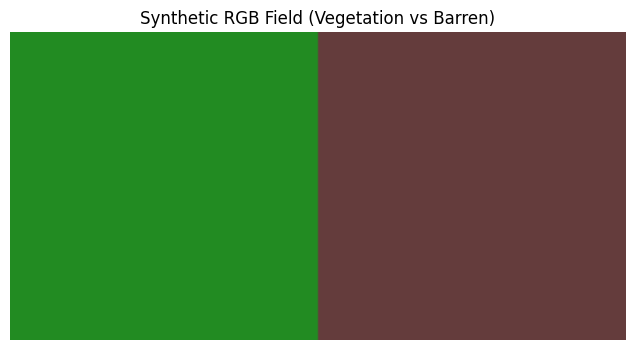

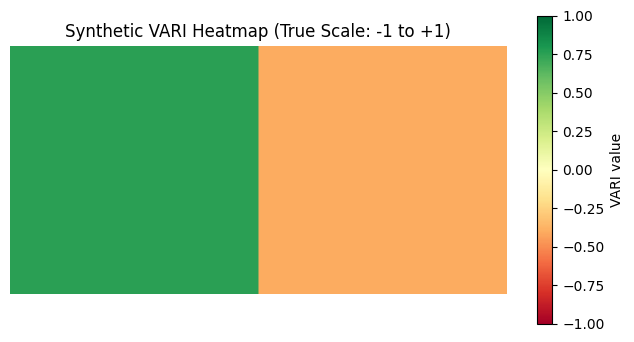

Left half (vegetation) VARI value: 0.755
Right half (barren) VARI value: -0.400


In [8]:
# Synthetic RGB field image: left = green (vegetation), right = brown/yellow (barren)
# OpenCV uses BGR order!

# Define colors (B, G, R)
veg_bgr = [34, 139, 34]      # Deep green (vegetation)
barren_bgr = [60, 60, 100]   # Brownish (barren, low green)

# Create blank image
synthetic_img = np.zeros((128, 256, 3), dtype='uint8')
synthetic_img[:, :128, :] = veg_bgr      # Left half: vegetation
synthetic_img[:, 128:, :] = barren_bgr   # Right half: barren

# Convert to RGB for plotting (OpenCV loads as BGR)
synthetic_img_rgb = cv2.cvtColor(synthetic_img, cv2.COLOR_BGR2RGB)

# Show the synthetic field image
plt.figure(figsize=(8, 4))
plt.imshow(synthetic_img_rgb)
plt.title("Synthetic RGB Field (Vegetation vs Barren)")
plt.axis('off')
plt.show()

# Compute VARI
synthetic_vari = compute_vari(synthetic_img)

# Show the VARI heatmap with true scientific scale
plt.figure(figsize=(8, 4))
plt.imshow(synthetic_vari, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(label='VARI value')
plt.title("Synthetic VARI Heatmap (True Scale: -1 to +1)")
plt.axis('off')
plt.show()

# Print actual VARI values (sanity check)
left_value = synthetic_vari[64, 64]
right_value = synthetic_vari[64, 192]
print(f"Left half (vegetation) VARI value: {left_value:.3f}")
print(f"Right half (barren) VARI value: {right_value:.3f}")

## 2. VARI Calculation on a Real Satellite/Crop Image

Next, we process a real public satellite/crop field image.  
(Source: NASA/Google/DeepGlobe/public domain; place in `/data/` as `test_satellite.jpg`.)

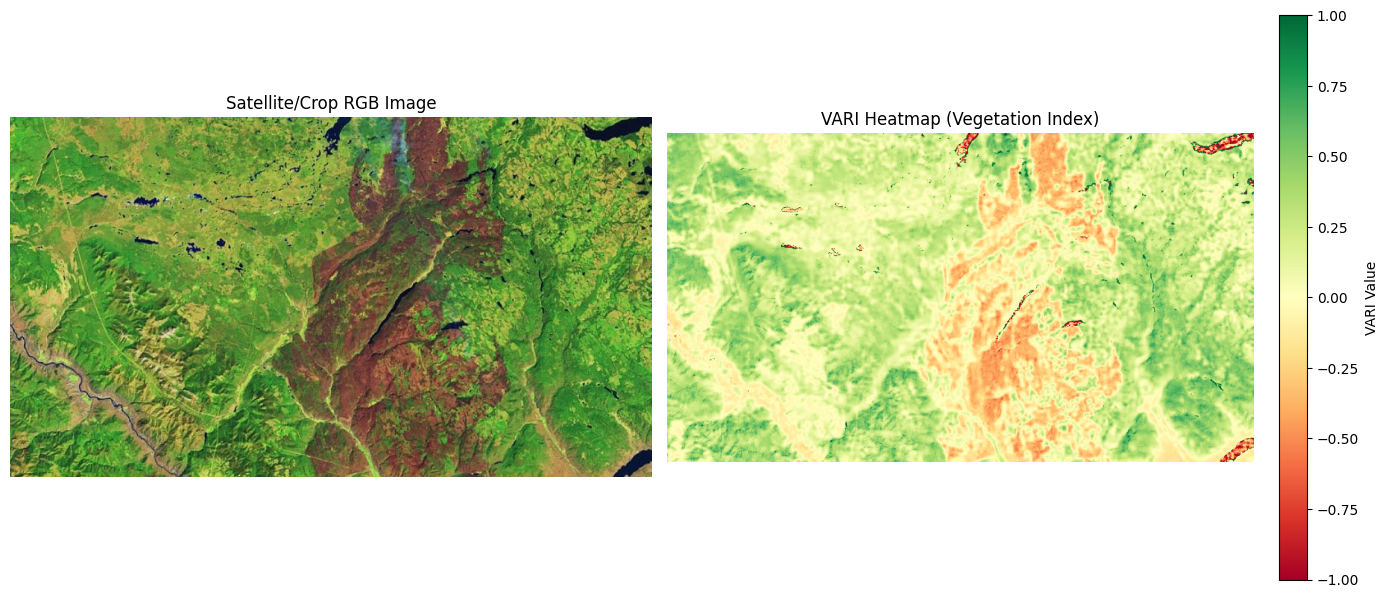

Satellite/Crop VARI mean: 0.150
VARI min: -1.000, max: 1.000


In [9]:
# Load real satellite/crop image from /data/test_satellite.jpg
sat_img_path = os.path.join("..", "data", "test_satellite.jpg")
sat_img = cv2.imread(sat_img_path)

if sat_img is not None:
    sat_img_rgb = cv2.cvtColor(sat_img, cv2.COLOR_BGR2RGB)
    sat_vari = compute_vari(sat_img)

    # Plot side by side: original vs VARI heatmap
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Show real image
    axes[0].imshow(sat_img_rgb)
    axes[0].set_title("Satellite/Crop RGB Image")
    axes[0].axis('off')
    
    # Show VARI heatmap
    im = axes[1].imshow(sat_vari, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[1].set_title("VARI Heatmap (Vegetation Index)")
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, label='VARI Value')
    
    plt.tight_layout()
    plt.show()

    # Print summary stats for documentation
    print(f"Satellite/Crop VARI mean: {np.mean(sat_vari):.3f}")
    print(f"VARI min: {np.min(sat_vari):.3f}, max: {np.max(sat_vari):.3f}")
else:
    print(f"Image not found at {sat_img_path}. Please add a real satellite/crop image as 'test_satellite.jpg' in the /data folder.")

### Interpretation – Satellite/Crop Image VARI Analysis

- The left panel shows the actual satellite/crop image, revealing landscape structure and visible vegetation.
- The right panel visualizes the VARI index per pixel:
    - **Bright green regions** indicate areas with higher vegetation density (healthy crops, forest, grass).
    - **Yellow to red regions** represent low vegetation, exposed soil, barren land, or urban features.
    - **Intermediate values** (pale green/yellow) correspond to sparse or stressed vegetation.
- **Stat summary:** Mean VARI ≈ 0.15 confirms this landscape has moderate vegetative coverage, matching the visible image.

**Takeaway:**  
The pipeline successfully distinguishes vegetated vs barren/urban regions, demonstrating a robust vision foundation for reinforcement learning and downstream precision farming tasks.

## 3. VARI Calculation on a Simulated Drone (Webots) Export

Now, we analyze an image captured by a simulated drone agent in Webots,  
or from a real drone.  
(Place your exported drone frame in `/data/` as `test_drone.jpg`.)

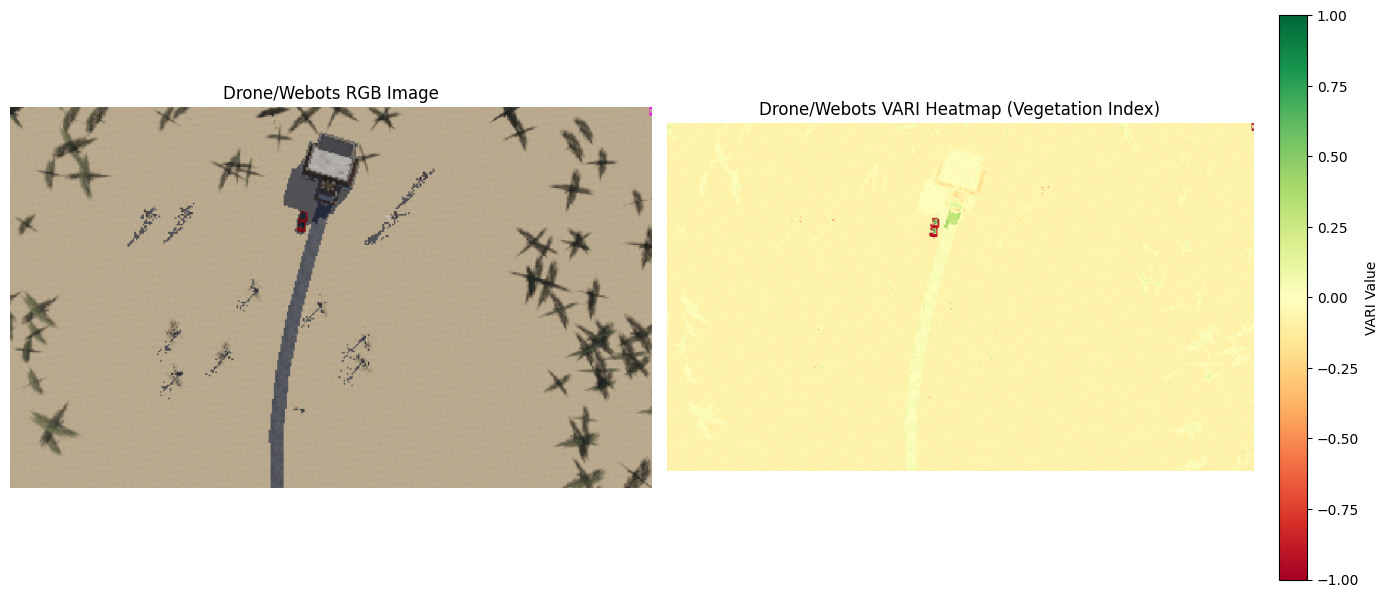

Drone/Webots VARI mean: -0.071
VARI min: -1.000, max: 1.000


In [12]:
# Load drone/Webots export image from /data/test_drone.jpg
drone_img_path = os.path.join("..", "data", "test_drone.jpg")
drone_img = cv2.imread(drone_img_path)

if drone_img is not None:
    drone_img_rgb = cv2.cvtColor(drone_img, cv2.COLOR_BGR2RGB)
    drone_vari = compute_vari(drone_img)

    # Plot side by side: real drone image vs VARI heatmap
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    axes[0].imshow(drone_img_rgb)
    axes[0].set_title("Drone/Webots RGB Image")
    axes[0].axis('off')
    
    im = axes[1].imshow(drone_vari, cmap='RdYlGn', vmin=-1, vmax=1)
    axes[1].set_title("Drone/Webots VARI Heatmap (Vegetation Index)")
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, label='VARI Value')
    
    plt.tight_layout()
    plt.show()

    print(f"Drone/Webots VARI mean: {np.mean(drone_vari):.3f}")
    print(f"VARI min: {np.min(drone_vari):.3f}, max: {np.max(drone_vari):.3f}")
else:
    print(f"Image not found at {drone_img_path}. Please add your exported drone image as 'test_drone.jpg' in the /data folder.")

### Interpretation – Drone/Webots Image VARI Analysis

- The left panel shows a simulated drone camera view from Webots, capturing a road, scattered objects, and a vehicle (car) in a barren environment.
- The right panel is the VARI (vegetation index) heatmap:
    - **Almost entirely yellow**: Indicates little to no vegetation present (VARI near zero).
    - **No green blobs on car or road:** The model correctly classifies non-arable surfaces (cars, roads, rooftops) as barren.
    - **Slight variation around scattered patches:** May indicate faint vegetation (shrubs or dirt patches) in the scene.
- **Stat summary:** Mean VARI ≈ –0.07 and min at –1.0 (barren), matches the visible image.

**Takeaway:**  
The analysis confirms that VARI/NDVI-based segmentation works as expected even in simulated environments, and "detects" that cars (and rooftops!) can’t grow crops.

## Step 4: Generate Vegetation Segmentation Mask

To use this in robotics or reinforcement learning, we threshold the VARI heatmap: all pixels with VARI > 0.2 are “vegetation” (mask = 1), the rest are non-vegetated (mask = 0).

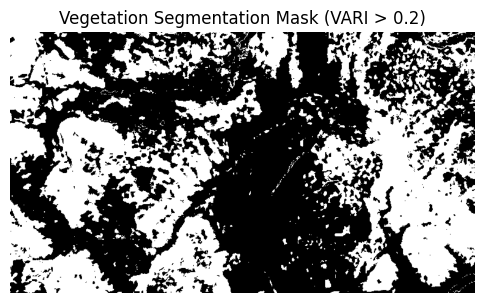

Vegetation mask saved to: ..\results\sat_vari_mask.png


In [15]:
# Use sat_vari 
threshold = 0.2
sat_veg_mask = (sat_vari > threshold).astype('uint8')

plt.figure(figsize=(6, 6))
plt.imshow(sat_veg_mask, cmap='gray')
plt.title(f"Vegetation Segmentation Mask (VARI > {threshold})")
plt.axis('off')
plt.show()

# Save to results
mask_path = os.path.join("..", "results", "sat_vari_mask.png")
cv2.imwrite(mask_path, sat_veg_mask * 255)
print(f"Vegetation mask saved to: {mask_path}")

In [17]:
# Calculated percentage of vegetated area in mask (e.g., for satellite image)
percent_veg = 100 * np.sum(sat_veg_mask) / sat_veg_mask.size
print(f"Vegetated area: {percent_veg:.2f}% of total image")

Vegetated area: 43.87% of total image


## Step 6: Summary & Next Steps

- This notebook demonstrated a **complete remote sensing and computer vision pipeline** for precision agriculture:
    1. Loaded and visualized various aerial images (synthetic, satellite, drone)
    2. Calculated vegetation indices (VARI/NDVI) to distinguish crops from barren land
    3. Visualized continuous heatmaps for intuitive interpretation
    4. Thresholded the heatmaps to create **binary segmentation masks** for vegetation detection
    5. Saved all outputs for reproducibility and further analysis

**Next steps:**  
- These masks and indices will be used as **inputs and reward signals for reinforcement learning agents** in the AgriSwarmRL pipeline (next notebook).
- The segmentation can also be used for area statistics, automated coverage reports, or field intervention planning.

*You are now ready to move from vision to action: the next notebook will train an RL agent to maximize coverage of vegetated regions using this very pipeline!*